<a href="https://colab.research.google.com/github/SeoJ2/dev/blob/main/2024_Tutorial_3_CNN_Edge_Detector_ipnb_20241123_%EB%AF%BC%EC%84%9C%EC%A0%95_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-image

## 1. 라이브러리 로드

필요한 라이브러리를 로드해줍니다.

In [2]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## 2. 데이터셋 로드

이번에도 [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) 데이터를 사용할 예정입니다.

CIFAR-10에 대한 데이터 살펴보기 예제는 [이 포스트](https://github.com/Intelligence-Engineering-LAB-KU/Deeplearning-Tutorial/blob/master/Tutorial%201%29%20CIFAR10_Softmax.ipynb)를 복습해주세요.

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


1번 인덱스에 위치한 말 이미지를 불러와보겠습니다.

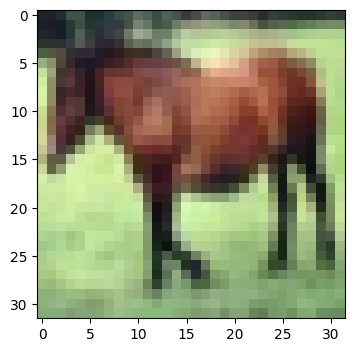

label:  [7]


In [4]:
plt.figure(figsize=(4,4))
plt.imshow(x_train[7].astype('uint8'), cmap=plt.cm.gray)
plt.show()

print('label: ', y_train[7])

### 3. Sobel Operator 복습

review: [지난 포스트](https://github.com/Intelligence-Engineering-LAB-KU/Deeplearning-Tutorial/blob/master/Tutorial_2_Sobel_Opearatior.ipynb)에서는 아래와 같은 Sobel opearatoin을 만들어 보았습니다.

그러나 for loop 기반으로 동작하는 코드는 벡터 연산을 활용하는 코드보다 동작이 느립니다. 이번 예제에서는

```python
from skimage.color import rgb2gray ## RGB 3채널 이미지를 흑백이미지로
from skimage.filters import sobel_h, sobel_v  ## sobel operator
```

위 라이브러리들을 이용하여 edge를 detection해볼 것입니다.

지난 포스트 방식과 큰 차이는 없지만, [padding](https://brunch.co.kr/@coolmindory/37) 기법이 추가되어 이미지의 사이즈가 이전과 달라지지 않으며,

결과값들이 0에서 1사이의 값을 가지도록 후처리를 한다는 점이 다릅니다.

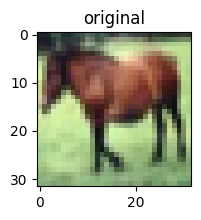

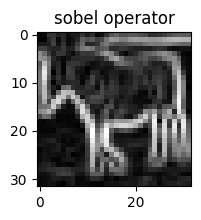

In [5]:
from skimage.filters import sobel_h, sobel_v
from skimage.color import rgb2gray

def sobel (image, thresold=180):
  grey_image = rgb2gray(image)
  convx = sobel_h(grey_image)
  convy = sobel_v(grey_image)
  output = np.sqrt(convx**2 + convy**2)
  return output

plt.figure(figsize=(2,2))
plt.imshow(x_train[7].astype('uint8'))
plt.title('original')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(sobel(x_train[7]), cmap=plt.cm.gray)
plt.title('sobel operator')
plt.show()

### 4. Sobel Opearator의 역할을 수행하는 Convolution Layer를 학습해보자.

4장에서는 Random으로 초기화된 Convolution Layer가 Sobel Operator와 같은 역할을 수행할 수 있는지 실험해보겠습니다.

즉, 우리의 목적은 model(img)의 결과가 sobel_operator(img) 와 비슷해지도록 model을 학습하는 것입니다.

그러기 위해 Keras의 [Conv2d API](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)를 이용하여 모델을 정의해보겠습니다.

```python
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)
```


#### 4.1. 학습 데이터 구축


정답 데이터는 더 이상 레이블인 y_train, y_test가 아니라, edge 이미지입니다.

따라서 다음과 같이 edge 이미지들을 만들어주겠습니다.

In [ ]:
# Conv2D: 이미지 데이터에 2D 컨볼루션 수행하여 특징 추출
# filter: 입력 이미지에서 특정한 패턴을 감지하여 출력 채널 수 결정
# kernel_size: 필터가 수용할 영역 크기 지정
# strides: 커널이 입력 이미지 이동하는 간격 지정 = 다운샘플링 효과, 계산비용 절감
# padding: 입력 이미지 가장자리 처리 방식 결정
# data_format: 이미지 데이터 형식 지정
# dilation_rate: 커널 요소 사이 픽셀 단위 간격 추가로 수용 영역 확장
# activation: 활성화 함수 지정으로 패턴 학습을 위한 비선형성 추가
 ## ReLU: 음수를 0으로 변환
# use_bias: 모델의 유연한 학습을 위한 레이어 편향 추가 여부 지정
# kernel_initializer: 커널 가중치 행렬 초기화 방법 지정
 ## glorot_uniform: Xavier 사용으로 가중치 초기화
# bias_initializer: 학습 수렴 속도 및 성능 조절을 위한 bias 벡터 초기화 방식 지정
# kernel_regularizer: 과적합 방지 및 학습 모델 일반화 성능 향상에 사용하는 정규화 방법
# 지정 -> 커널 가중치 행렬 적용
# bias_regularizer: 편향 벡터 정규화 적용 방식 지정
# activity_regularizer: 모델 레이어 출력 정규화 방식 지정
# kernel_constraint: 커널 가중치 행렬 범위 제한하여 안정성 향상을 위한 제약조건 지정
# bias_constraint: 편향 벡터 제약조건 지정
# **kwargs: 사용자 정의 레이어에서 추가 지정된 매개변수 전달

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

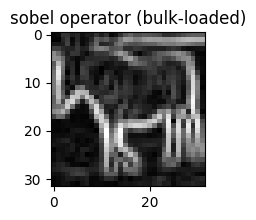

In [6]:
sobel_train = np.array([sobel(img) for img in tqdm(x_train)])
sobel_test  = np.array([sobel(img) for img in tqdm(x_test)])

plt.figure(figsize=(2,2))
plt.imshow(sobel_train[7], cmap=plt.cm.gray)
plt.title('sobel operator (bulk-loaded)')
plt.show()

#### 4.2. 모델 정의

Sobel Operator는 먼저 gray scale로 이미지를 변환한 후, 두 개의 커널로 convolution 연산을 수행하고

마지막으로 $G_{x}$ 와 $G_{y}$ 의 크기를 잽니다.

이 과정을 3계층의 Convolution Layer들이 모사한다고 가정하고 다음과 같은 모델을 만들어보겠습니다.

In [7]:
from tensorflow.keras.models import Sequential #레이어 순차 구성 모델
from tensorflow.keras.layers import Conv2D, LeakyReLU
from keras.regularizers import l1

tf.random.set_seed(2020) #초기 가중치와 동일한 재현성 보장을 위한 랜덤 시드 설정

model = Sequential([
    Conv2D(filters=2,kernel_size=(3,3), padding='same', activation='relu',    kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    Conv2D(filters=4,kernel_size=(3,3), padding='same', activation='relu',    kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
    Conv2D(filters=1,kernel_size=(1,1), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
])

# filters: 출력 채널 설정
# kernel_size: 커널 크기 지정
# padding: 출력크기와 입력 크기 동일 유지
# activation: 비선형성 추가로 인한 신경망 모델 표현력 증진
# kernel_initializer='he_normal': relu 함수 적용 학습 안정화와 수렴 속도 증가를 위한 He 초기화
# kernel_regularizer=l1(1e-4): 가중치 절대값의 합을 최소화해 과적합 방지 유도하는 L1 정규화
# input_shape: 32X32 RGB 입력 이미지 크기 지정

## Conv2D 1차: 필터 수 2개 적용
### Conv2D 2차: 출력 채널 4개로 증가시켜 심화된 특징 추출
### Conv2D 3차: 단일 출력 채널 사용 = 최종 출력 레이어

# kernel_size=(1, 1): 1X1 커널 사용으로 특징 맵 크기 유지
# activation='sigmoid': 출력을 0과 1 사이로 제한

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


이제 총 $N$개의 이미지에 대해
모델이 추정한 $i$번째 edge 이미지 $model(img_{i})$와 sobel operator의 결과물인 $G^{img_{i}}$ 사이의 차이를 정량화하기 위해, 다음과 같은 손실 함수를 사용한다고 가정해보겠습니다.

$MAE= \sum_{i}^N\sum_{p \in pixels}|model(img_{i})_{p}-G_{p}^{img_{i}}|$

Keras에서는 위 손실함수를 keras.losses.MeanAbsoluteError() 에서 지원합니다.

이제 아래와 같이 MAE 손실함수를 쓰며 Adam optimizer에 의해 최적화되는 모델을 컴파일해보겠습니다.

In [8]:
## 학습가능한 필터를 가지고 있는 CNN으로 sobel operation을 학습해보자
model.compile(
          loss=keras.losses.MeanAbsoluteError(),
          optimizer=keras.optimizers.Adam())



훈련 전이므로, 다음과 같이 모델에 말 이미지를 넣으면 노이즈에 가까운 결과가 생성될 것입니다.

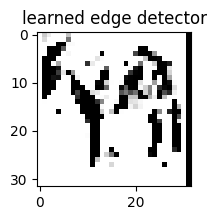

In [9]:
def learned_edge_detection (model, img):
  return model(img.reshape(-1,32,32,3)).numpy()[0,:,:,0]

plt.figure(figsize=(2,2))
plt.imshow(learned_edge_detection(model, x_train[7]), cmap=plt.cm.gray)
plt.title('learned edge detector')
plt.show()

#### 4.3 모델 훈련

그렇다면, 이제 모델을 훈련시켜보겠습니다.


In [10]:
model.fit(x_train, sobel_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, sobel_test),
          shuffle=True)



Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1904 - val_loss: 0.1357
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1358 - val_loss: 0.1350
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1352 - val_loss: 0.1346
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1348 - val_loss: 0.1342
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1345 - val_loss: 0.1337
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1341 - val_loss: 0.1335
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1338 - val_loss: 0.1333
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1336 - val_loss: 0.1333
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1260 - val_loss: 0.0920
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0902 - val_loss: 0.0841


훈련된 모델로 edge detector를 만들어 본 후, 이를 가시화해보겠습니다.

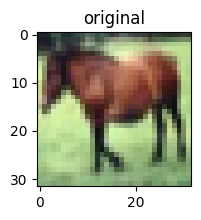

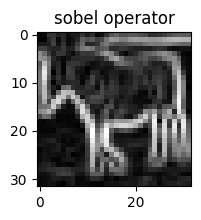

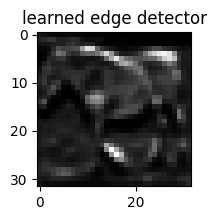

In [11]:
plt.figure(figsize=(2,2))
plt.imshow(x_train[7].astype('uint8'))
plt.title('original')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(sobel(x_train[7]), cmap=plt.cm.gray)
plt.title('sobel operator')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(learned_edge_detection(model, x_train[7]), cmap=plt.cm.gray)
plt.title('learned edge detector')
plt.show()

#### 4.4 훈련 결과 확인해보기

훈련이 완료된 후에는 어느정도 말 이미지의 edge를 잘 찾아낸 것 같습니다!

이번에는 학습된 edge detector로 다양한 이미지의 edge를 찾아보겠습니다.

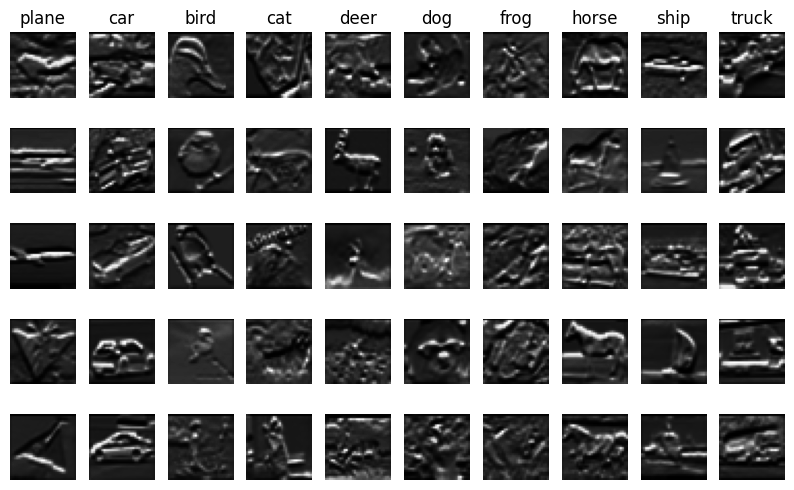

In [12]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5

plt.figure(figsize=(10,6))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(learned_edge_detection(model,x_train[idx]), cmap=plt.cm.gray)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

#### 4.4 학습된 Weight 출력해보기

학습된 Weight들이 어떤지 출력해보겠습니다.

In [13]:
print(model.weights)

[<KerasVariable shape=(3, 3, 3, 2), dtype=float32, path=sequential/conv2d/kernel>, <KerasVariable shape=(2,), dtype=float32, path=sequential/conv2d/bias>, <KerasVariable shape=(3, 3, 2, 4), dtype=float32, path=sequential/conv2d_1/kernel>, <KerasVariable shape=(4,), dtype=float32, path=sequential/conv2d_1/bias>, <KerasVariable shape=(1, 1, 4, 1), dtype=float32, path=sequential/conv2d_2/kernel>, <KerasVariable shape=(1,), dtype=float32, path=sequential/conv2d_2/bias>]



## Reference

- [cs231n](http://cs231n.github.io/)
- [Keras tutorial on CIFAR-10](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py)

In [14]:
pip install scikit-image


#개선방안
1) Batch 정규화 추가 도입으로 학습 속도와 안정성 향상
2) Dropout 레이어 추가 도입으로 학습 과적합 방지
3) ReLU 함수 단점 극복을 위한 LeakyReLU 사용
4) 데이터 증강 기법 도입

x_train shape: (50000, 32, 32, 3)
sobel_train shape: (50000, 32, 32, 1)
x_test shape: (10000, 32, 32, 3)
sobel_test shape: (10000, 32, 32, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.2969 - val_loss: 0.1789 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.2197 - val_loss: 0.1723 - learning_rate: 0.0010
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2157 - val_loss: 0.1692 - learning_rate: 0.0010
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2115 - val_loss: 0.1664 - learning_rate: 0.0010
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2100 - val_loss: 0.1649 - learning_rate: 0.0010
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2093 - val_loss: 0.1652 - learning_rate: 0.0010
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2089 - val_loss: 0.1652 - learning_rate: 0.0010
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2086 - val_loss: 0.1649 - learning_rate: 0.0010
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2084 - val_loss: 0.1637 - learning_rat

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,805 (18.77 KB)

 Trainable params: 1,585 (6.19 KB)

 Non-trainable params: 48 (192.00 B)

 Optimizer params: 3,172 (12.39 KB)

Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: (1, 32, 32, 1)
Model output shape: 

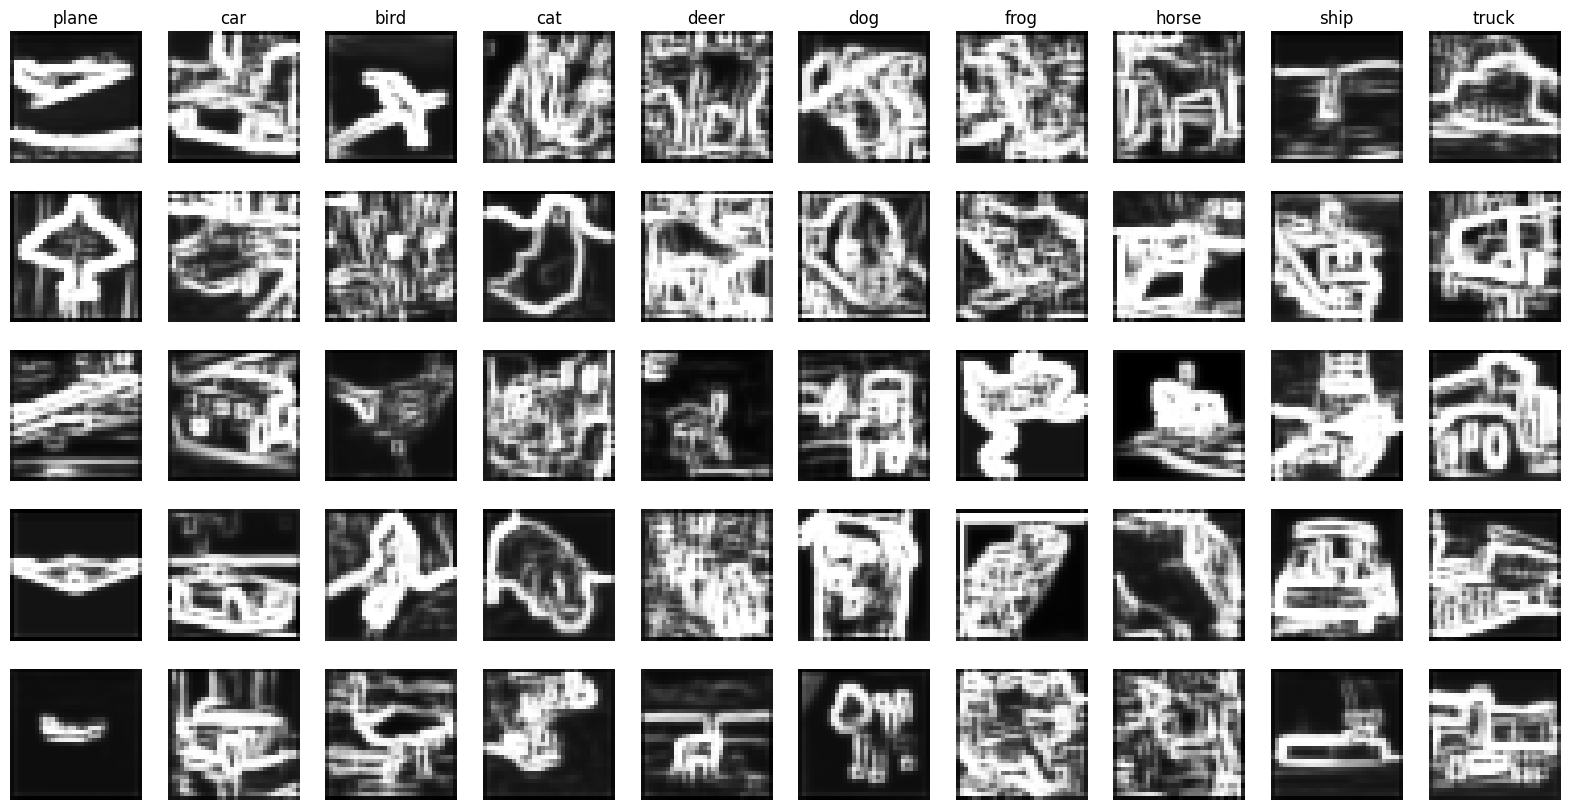

In [15]:
#######1차 성능 개선 #######

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dropout
from keras.regularizers import l1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt


tf.random.set_seed(2020) #랜덤 시드를 설정 초기 데이터 재현성 보장


(x_train, y_train), (x_test, y_test) = cifar10.load_data() #CIFAR-10 데이터셋 로드


x_train = x_train.astype('float32') / 255.0 #데이터 전처리
x_test = x_test.astype('float32') / 255.0


def apply_sobel_filter(images): #Sobel 필터 적용
    grey_images = tf.image.rgb_to_grayscale(images)
    sobel_edges = tf.image.sobel_edges(grey_images)
    sobel_x = sobel_edges[..., 0]
    sobel_y = sobel_edges[..., 1]
    sobel_images = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))
    return sobel_images.numpy()


sobel_train = apply_sobel_filter(x_train) # 학습 데이터 Sobel 필터 적용
sobel_test = apply_sobel_filter(x_test)


print("x_train shape:", x_train.shape) # 학습 및 훈련 데이터셋 크기 확인
print("sobel_train shape:", sobel_train.shape)
print("x_test shape:", x_test.shape)
print("sobel_test shape:", sobel_test.shape)


model = Sequential([ #Sequential 모델을 생성
    Conv2D(filters=8, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),

    Conv2D(filters=16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),

    Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4))
])


model.compile( #모델 컴파일
    loss=tf.keras.losses.MeanAbsoluteError(),
    optimizer=tf.keras.optimizers.Adam()
)

# 학습률 조정 콜백 설정
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


history = model.fit(x_train, sobel_train, #모델 학습
                    batch_size=32,
                    epochs=20,  #에포크 수 증량
                    validation_data=(x_test, sobel_test),
                    shuffle=True,
                    callbacks=[reduce_lr])


model.summary() #모델 요약 출력으로 각 레이어 구성 및 파라미터 수 확인


def learned_edge_detection(model, img): #엣지 검출

    if img.shape != (32, 32, 3): #이미지 형태가 (32, 32, 3)이 아니면 변환
        raise ValueError("Input image must have shape (32, 32, 3)")


    img_batch = img.reshape(-1, 32, 32, 3) # 모델 입력시 배치 차원 추가


    output = model(img_batch).numpy() #모델 예측 수행 후 결과를 numpy 배열 변환


    print("Model output shape:", output.shape)#모델 출력 형태 확인


    return output[0, :, :, 0] #첫 번째 배치 첫 번째 채널 반환

# 클래스별 샘플 이미지 시각화
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5

plt.figure(figsize=(20, 10))  #이미지 크기 증설
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    if len(idxs) == 0:
        continue
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(learned_edge_detection(model, x_train[idx]), cmap=plt.cm.gray)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# 2차 #

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dropout
from keras.regularizers import l1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt


tf.random.set_seed(2020) #랜덤 시드 설정으로 초기 데이터 재현성 보장


(x_train, y_train), (x_test, y_test) = cifar10.load_data() #CIFAR-10 데이터셋 로드


x_train = x_train.astype('float32') / 255.0 #데이터 전처리
x_test = x_test.astype('float32') / 255.0


def apply_sobel_filter(images): #Sobel 필터 적용
    grey_images = tf.image.rgb_to_grayscale(images)
    sobel_edges = tf.image.sobel_edges(grey_images)
    sobel_x = sobel_edges[..., 0]
    sobel_y = sobel_edges[..., 1]
    sobel_images = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))
    return sobel_images.numpy()


sobel_train = apply_sobel_filter(x_train) #학습 데이터 Sobel 필터 적용
sobel_test = apply_sobel_filter(x_test)


print("x_train shape:", x_train.shape) # 학습 및 훈련 데이터셋 크기 확인
print("sobel_train shape:", sobel_train.shape)
print("x_test shape:", x_test.shape)
print("sobel_test shape:", sobel_test.shape)

model0 = Sequential([ # 최초 제시모델
    Conv2D(filters=2,kernel_size=(3,3), padding='same', activation='relu',    kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    Conv2D(filters=4,kernel_size=(3,3), padding='same', activation='relu',    kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
    Conv2D(filters=1,kernel_size=(1,1), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
])

model = Sequential([ #Sequential 모델 생성
    Conv2D(filters=8, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),

    Conv2D(filters=16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),

    Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4))
])


model.compile( #모델 컴파일
    loss=tf.keras.losses.MeanAbsoluteError(),
    optimizer=tf.keras.optimizers.Adam()
)

# 학습률 조정 콜백 설정
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


history = model.fit(x_train, sobel_train, #모델 학습
                    batch_size=32,
                    epochs=20,  #에포크 수 증량
                    validation_data=(x_test, sobel_test),
                    shuffle=True,
                    callbacks=[reduce_lr])


model.summary()  #모델 요약 출력으로 각 레이어 구성 및 파라미터 수 확인


def learned_edge_detection(model, img): #엣지 검출

    if img.shape != (32, 32, 3): #이미지 형태가 (32, 32, 3)이 아니면 변환
        raise ValueError("Input image must have shape (32, 32, 3)")

    img_batch = img.reshape(-1, 32, 32, 3) # 모델 입력시 배치 차원 추가


    output = model(img_batch).numpy() #모델 예측 수행 후 결과를 numpy 배열 변환


    print("Model output shape:", output.shape)#모델 출력 형태 확인


    return output[0, :, :, 0] #첫 번째 배치 첫 번째 채널 반환


# 클래스별 샘플 이미지 시각화
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5

plt.figure(figsize=(20, 10))  #이미지 크기 증설
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    if len(idxs) == 0:
        continue
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(learned_edge_detection(model, x_train[idx]), cmap=plt.cm.gray)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [17]:

 #Total params: 4,805 (18.77 KB) // 모델 복잡도
 #Trainable params: 1,585 (6.19 KB) // 학습으로 조절 가능한 가중치, 폎ㄴ향
 #Non-trainable params: 48 (192.00 B) // 배치 일반화 레이어 사용 위한 고정 학습 값
 #Optimizer params: 3,172 (12.39 KB) // 모델 학습 최적화를 위한 추가 파라미터

In [18]:
print(model.weights)

[<KerasVariable shape=(3, 3, 3, 8), dtype=float32, path=sequential_3/conv2d_9/kernel>, <KerasVariable shape=(8,), dtype=float32, path=sequential_3/conv2d_9/bias>, <KerasVariable shape=(8,), dtype=float32, path=sequential_3/batch_normalization_2/gamma>, <KerasVariable shape=(8,), dtype=float32, path=sequential_3/batch_normalization_2/beta>, <KerasVariable shape=(8,), dtype=float32, path=sequential_3/batch_normalization_2/moving_mean>, <KerasVariable shape=(8,), dtype=float32, path=sequential_3/batch_normalization_2/moving_variance>, <KerasVariable shape=(3, 3, 8, 16), dtype=float32, path=sequential_3/conv2d_10/kernel>, <KerasVariable shape=(16,), dtype=float32, path=sequential_3/conv2d_10/bias>, <KerasVariable shape=(16,), dtype=float32, path=sequential_3/batch_normalization_3/gamma>, <KerasVariable shape=(16,), dtype=float32, path=sequential_3/batch_normalization_3/beta>, <KerasVariable shape=(16,), dtype=float32, path=sequential_3/batch_normalization_3/moving_mean>, <KerasVariable sha

In [ ]:
## 원본 데이터와 1차,2차 성능 개선 비교 ##


tf.random.set_seed(2020) #랜덤 시드 설정으로 초기 데이터 재현성 보장

# CIFAR-10 데이터셋 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 데이터 전처리
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 벡터화된 Sobel 필터 적용 함수
def apply_sobel_filter(images):
    grey_images = tf.image.rgb_to_grayscale(images)
    sobel_edges = tf.image.sobel_edges(grey_images)
    sobel_x = sobel_edges[..., 0]
    sobel_y = sobel_edges[..., 1]
    sobel_images = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))
    return sobel_images.numpy()

# Sobel 필터 적용
sobel_train = apply_sobel_filter(x_train)
sobel_test = apply_sobel_filter(x_test)

# Sequential 모델을 생성합니다.

model0 = Sequential([ #최초 모델
    Conv2D(filters=2,kernel_size=(3,3), padding='same', activation='relu',    kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    Conv2D(filters=4,kernel_size=(3,3), padding='same', activation='relu',    kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
    Conv2D(filters=1,kernel_size=(1,1), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
])

# 모델 컴파일

model0.compile(
          loss=keras.losses.MeanAbsoluteError(),
          optimizer=keras.optimizers.Adam())


# 학습률 조정 콜백 설정
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# 모델 0 학습
history0 = model0.fit(x_train, sobel_train,
                    batch_size=32,
                    epochs=20,  # 에포크 수를 늘립니다.
                    validation_data=(x_test, sobel_test),
                    shuffle=True,
                    callbacks=[reduce_lr])

# 모델 1 정의 및 학습 (예: 더 많은 필터와 레이어 추가)
model1 = Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4))
])

model1.compile(
    loss=tf.keras.losses.MeanAbsoluteError(),
    optimizer=tf.keras.optimizers.Adam()
)

history1 = model1.fit(x_train, sobel_train,
                      batch_size=32,
                      epochs=20,
                      validation_data=(x_test, sobel_test),
                      shuffle=True,
                      callbacks=[reduce_lr])

 ### model_2##3


# 모델 요약 출력
model0.summary()
model1.summary()

# 손실 값 비교
def plot_loss(history1, history2):
    plt.figure(figsize=(12, 6))
    plt.plot(history1.history['loss'], label='Model 1 Training Loss')
    plt.plot(history1.history['val_loss'], label='Model 1 Validation Loss')
    plt.plot(history2.history['loss'], label='Model 2 Training Loss')
    plt.plot(history2.history['val_loss'], label='Model 2 Validation Loss')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 시각적 비교
def compare_edge_detection(model0, model1, img):
    edge1 = learned_edge_detection(model0, img)
    edge2 = learned_edge_detection(model1, img)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(edge1, cmap='gray')
    plt.title('Model 1 Edge Detection')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(edge2, cmap='gray')
    plt.title('Model 2 Edge Detection')
    plt.axis('off')

    plt.show()

# 예제 데이터
img_example = x_test[0]

# 손실 값 비교
plot_loss(history0, history1)

# 시각적 비교
compare_edge_detection(model0, model1, img_example)




In [ ]:
#### 3차 ####
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dropout, Add, Input
from keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt


tf.random.set_seed(2020)# 랜덤 시드를 설정으로 초기 재현성 보장


(x_train, y_train), (x_test, y_test) = cifar10.load_data() # CIFAR-10 데이터셋 로드


x_train = x_train.astype('float32') / 255.0 # 데이터 전처리
x_test = x_test.astype('float32') / 255.0


def apply_sobel_filter(images):# Sobel 필터 적용 함수 설정
    grey_images = tf.image.rgb_to_grayscale(images)
    sobel_edges = tf.image.sobel_edges(grey_images)
    sobel_x = sobel_edges[..., 0]
    sobel_y = sobel_edges[..., 1]
    sobel_images = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))
    return sobel_images.numpy()


sobel_train = apply_sobel_filter(x_train)# Sobel 필터 적용
sobel_test = apply_sobel_filter(x_test)


datagen = ImageDataGenerator(# 데이터 증강 설정
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


def residual_block(x, filters, kernel_size=3, stride=1, activation='relu'):# Residual Block 정의
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = LeakyReLU()(x)
    return x


input_shape = (32, 32, 3)#입력 모델 정의
inputs = Input(shape=input_shape)
x = Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.5)(x)

x = residual_block(x, 16)
x = residual_block(x, 16)

x = Conv2D(1, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)

model = tf.keras.Model(inputs, x)


def scheduler(epoch, lr):# 학습률 스케줄 정의
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)

# 모델 컴파일
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


history = model.fit(datagen.flow(x_train, sobel_train, batch_size=32), # 모델 학습
                    epochs=20,
                    validation_data=(x_test, sobel_test),
                    callbacks=[lr_scheduler])


model.summary()# 모델 요약 출력으로 각 레이어의 구성과 파라미터 수를 확인


def learned_edge_detection(model, img):#엣지 검출 함수
    if img.shape != (32, 32, 3):
        raise ValueError("Input image must have shape (32, 32, 3)")
    img_batch = img.reshape(-1, 32, 32, 3)
    output = model(img_batch).numpy()
    print("Model output shape:", output.shape)
    return output[0, :, :, 0]


classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']# 클래스별 샘플 이미지 시각화
num_classes = len(classes)
samples_per_class = 5

plt.figure(figsize=(20, 10))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    if len(idxs) == 0:
        continue
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(learned_edge_detection(model, x_train[idx]), cmap=plt.cm.gray)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3465 - val_loss: 0.2653 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.2597 - val_loss: 0.2478 - learning_rate: 0.0010
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2462 - val_loss: 0.2404 - learning_rate: 0.0010
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2399 - val_loss: 0.2368 - learning_rate: 0.0010
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2368 - val_loss: 0.2348 - learning_rate: 0.0010
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2351 - val_loss: 0.2336 - learning_rate: 0.0010
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2340 - val_loss: 0.2327 - learning_rate: 0.0010
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2331 - val_loss: 0.2312 - learning_rate: 0.0010
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2277 - val_loss: 0.2155 - learning_rate:

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 32, 32, 2)           │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 32, 32, 4)           │              76 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 32, 32, 1)           │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 413 (1.62 KB)

 Trainable params: 137 (548.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 276 (1.08 KB)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,517 (64.52 KB)

 Trainable params: 5,473 (21.38 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 10,948 (42.77 KB)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 32, 32, 16)     │            448 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 32, 32, 16)     │             64 │ conv2d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_18            │ (None, 32, 32, 16)     │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 32, 32, 16)     │              0 │ leaky_re_lu_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 32, 32, 16)     │          2,320 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 32, 32, 16)     │             64 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_19            │ (None, 32, 32, 16)     │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 32, 32, 16)     │          2,320 │ leaky_re_lu_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 32, 32, 16)     │             64 │ conv2d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 32, 32, 16)     │            272 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 32, 32, 16)     │              0 │ batch_normalization_2… │
│                           │                        │                │ conv2d_37[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_20            │ (None, 32, 32, 16)     │              0 │ add_4[0][0]            │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 32, 32, 16)     │          2,320 │ leaky_re_lu_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 32, 32, 16)     │             64 │ conv2d_41[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 31,893 (124.59 KB)

 Trainable params: 10,577 (41.32 KB)

 Non-trainable params: 160 (640.00 B)

 Optimizer params: 21,156 (82.64 KB)

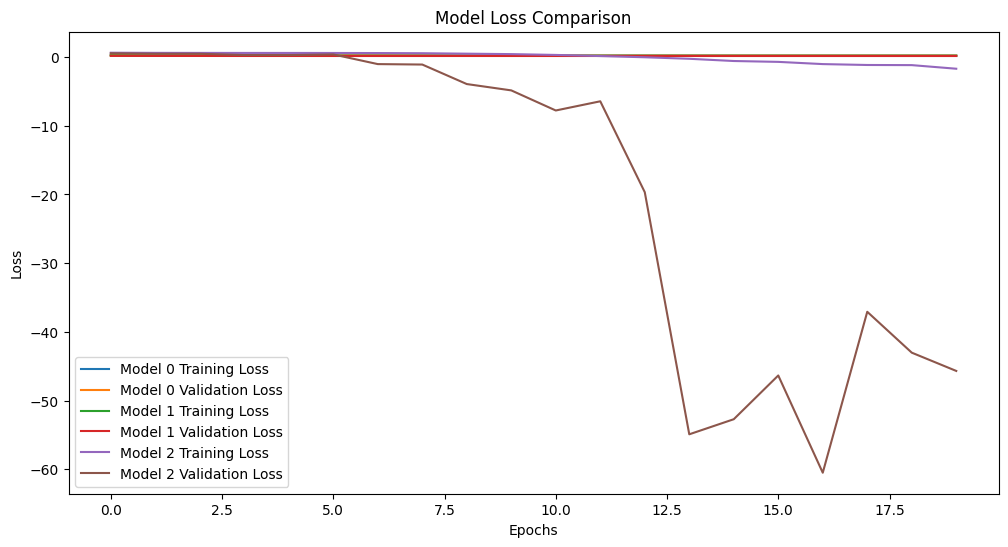

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


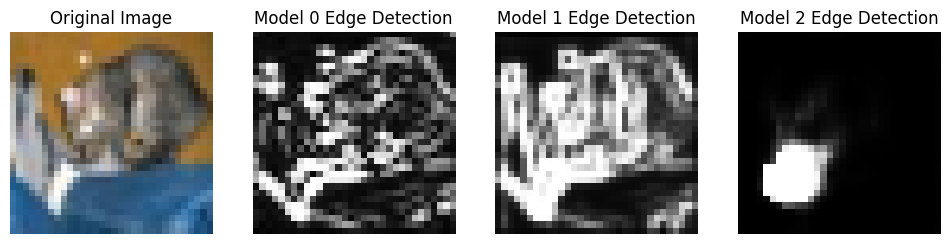

In [21]:
## 0,1,2차 개선 포함 ##_추가 시도 1차
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dropout, Add, Input
from keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt


tf.random.set_seed(2020) #랜덤 시드 설정으로 초기 데이터 재현성 보장


(x_train, y_train), (x_test, y_test) = cifar10.load_data() #CIFAR-10 데이터셋 로드


x_train = x_train.astype('float32') / 255.0 #데이터 전처리
x_test = x_test.astype('float32') / 255.0


def apply_sobel_filter(images):#벡터화 Sobel 필터 적용
    grey_images = tf.image.rgb_to_grayscale(images)
    sobel_edges = tf.image.sobel_edges(grey_images)
    sobel_x = sobel_edges[..., 0]
    sobel_y = sobel_edges[..., 1]
    sobel_images = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))
    return sobel_images.numpy()

#Sobel 필터 적용
sobel_train = apply_sobel_filter(x_train)
sobel_test = apply_sobel_filter(x_test)

#원본 모델 정의 및 학습
model0 = Sequential([
    Conv2D(filters=2, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    Conv2D(filters=4, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
    Conv2D(filters=1, kernel_size=(1, 1), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
])

model0.compile(
    loss=tf.keras.losses.MeanAbsoluteError(),
    optimizer=tf.keras.optimizers.Adam()
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history0 = model0.fit(x_train, sobel_train,
                      batch_size=32,
                      epochs=20,
                      validation_data=(x_test, sobel_test),
                      shuffle=True,
                      callbacks=[reduce_lr])

#성능 개선 모델 1차 정의 및 학습
model1 = Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4))
])

model1.compile(
    loss=tf.keras.losses.MeanAbsoluteError(),
    optimizer=tf.keras.optimizers.Adam()
)

history1 = model1.fit(x_train, sobel_train,
                      batch_size=32,
                      epochs=20,
                      validation_data=(x_test, sobel_test),
                      shuffle=True,
                      callbacks=[reduce_lr])

#데이터 증강 설정
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

#Residual Block 정의
def residual_block(x, filters, kernel_size=3, stride=1, activation='relu'):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = LeakyReLU()(x)
    return x

#성능 개선 모델 2차 정의 및 학습
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)
x = Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.5)(x)

x = residual_block(x, 16)
x = residual_block(x, 16)

x = Conv2D(1, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)

model2 = tf.keras.Model(inputs, x)


def scheduler(epoch, lr): #학습률 재구성
    if epoch < 10:
        return lr * 0.99  #매 에포크마다 학습률을 0.99배 감소 유도
    else:
        return lr * 0.9   #10 epoch 이후 학습률 0.9배 감소

#Residual Block 정의
def residual_block(x, filters, kernel_size=3, stride=1, activation='relu'):
    shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)  # stride 적용된 shortcut 경로
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)  # strides=1로 설정
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = LeakyReLU()(x)
    return x


input_shape = (32, 32, 3) #성능 개선 모델 2차 정의 및 학습
inputs = Input(shape=input_shape)
x = Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)  #Dropout 비율 조정

x = residual_block(x, 16)
x = residual_block(x, 16)

x = Conv2D(1, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)

model2 = tf.keras.Model(inputs, x)


model2.compile(# 모델 컴파일
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # 초기 학습률 조정
    metrics=['accuracy']
)


history2 = model2.fit(datagen.flow(x_train, sobel_train, batch_size=32), #성능개선 2차 모델 학습
                      epochs=20,
                      validation_data=(x_test, sobel_test),
                      callbacks=[lr_scheduler])


#모델 요약 출력
model0.summary() # 원본
model1.summary() # 성능개선 1차
model2.summary() # 성능개선 2차


def plot_loss(history0, history1, history2):#실행 모델별 손실 값 비교
    plt.figure(figsize=(12, 6))
    plt.plot(history0.history['loss'], label='Model 0 Training Loss')
    plt.plot(history0.history['val_loss'], label='Model 0 Validation Loss')
    plt.plot(history1.history['loss'], label='Model 1 Training Loss')
    plt.plot(history1.history['val_loss'], label='Model 1 Validation Loss')
    plt.plot(history2.history['loss'], label='Model 2 Training Loss')
    plt.plot(history2.history['val_loss'], label='Model 2 Validation Loss')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def learned_edge_detection(model, img):#에지 감지 함수 정의
    img = np.expand_dims(img, axis=0)  #배치 차원 추가
    edge_detected_img = model.predict(img)
    return edge_detected_img[0]  #배치 차원 제거


def compare_edge_detection(model0, model1, model2, img): #시각적 비교
    edge0 = learned_edge_detection(model0, img)
    edge1 = learned_edge_detection(model1, img)
    edge2 = learned_edge_detection(model2, img)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(edge0, cmap='gray')
    plt.title('Model 0 Edge Detection')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(edge1, cmap='gray')
    plt.title('Model 1 Edge Detection')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(edge2, cmap='gray')
    plt.title('Model 2 Edge Detection')
    plt.axis('off')

    plt.show()


img_example = x_test[0] #예제 데이터


plot_loss(history0, history1, history2) #각 성능 모델 손실 값 비교


compare_edge_detection(model0, model1, model2, img_example)#시각적 비교

## model2의 Loss,val_loss 손실값 변동 위해 조정 후 재시도

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3481 - val_loss: 0.2264 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2229 - val_loss: 0.2161 - learning_rate: 0.0010
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2155 - val_loss: 0.2124 - learning_rate: 0.0010
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2122 - val_loss: 0.2103 - learning_rate: 0.0010
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2103 - val_loss: 0.2090 - learning_rate: 0.0010
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2092 - val_loss: 0.2083 - learning_rate: 0.0010
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2086 - val_loss: 0.2078 - learning_rate: 0.0010
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2082 - val_loss: 0.2075 - learning_rate: 0.0010
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2079 - val_loss: 0.2072 - learning_rate:

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)                   │ (None, 32, 32, 2)           │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 32, 32, 4)           │              76 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 32, 32, 1)           │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 413 (1.62 KB)

 Trainable params: 137 (548.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 276 (1.08 KB)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_47 (Conv2D)                   │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 32, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_23 (LeakyReLU)           │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_24 (LeakyReLU)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,517 (64.52 KB)

 Trainable params: 5,473 (21.38 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 10,948 (42.77 KB)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 32, 32, 16)     │            448 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 32, 32, 16)     │             64 │ conv2d_50[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_25            │ (None, 32, 32, 16)     │              0 │ batch_normalization_2… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 32, 32, 16)     │              0 │ leaky_re_lu_25[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 32, 32, 16)     │          2,320 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_26    │ (None, 32, 32, 16)     │             64 │ conv2d_52[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_26            │ (None, 32, 32, 16)     │              0 │ batch_normalization_2… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 32, 32, 16)     │          2,320 │ leaky_re_lu_26[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 32, 32, 16)     │             64 │ conv2d_53[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 32, 32, 16)     │            272 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 32, 32, 16)     │              0 │ batch_normalization_2… │
│                           │                        │                │ conv2d_51[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_27            │ (None, 32, 32, 16)     │              0 │ add_6[0][0]            │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 32, 32, 16)     │          2,320 │ leaky_re_lu_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 32, 32, 16)     │             64 │ conv2d_55[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 31,893 (124.59 KB)

 Trainable params: 10,577 (41.32 KB)

 Non-trainable params: 160 (640.00 B)

 Optimizer params: 21,156 (82.64 KB)

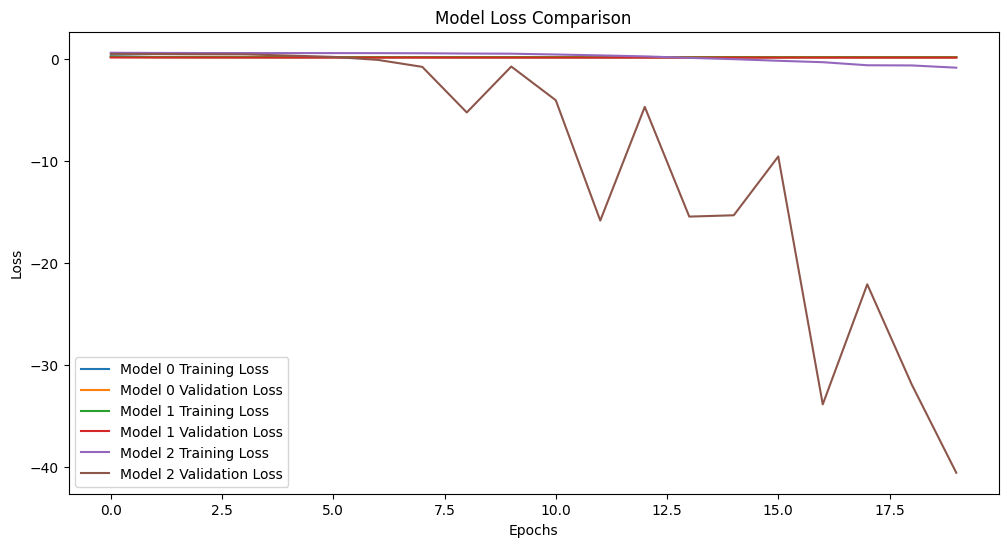

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


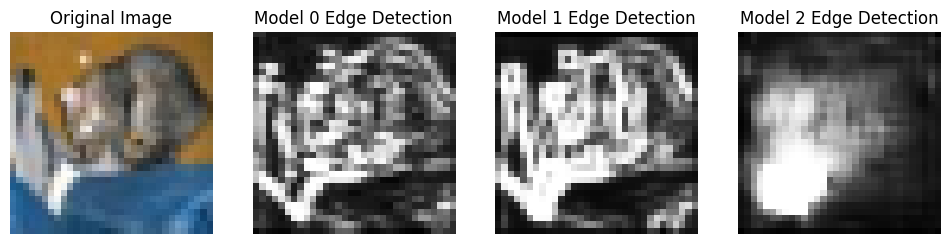

In [22]:
################ model 2 에지 검출 능력 개선 추가##########

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential #layer의 선형 스택으로 정의/모델 프로토타이핑 가능
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dropout, Add, Input
from keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
#Conv2D: 2차원 컨볼루션 층, 이미지 데이터 처리 사용
#LeakyReLU: Leaky Rectified Linear Unit 활성화 함수, vanishing gradient 문제 완화
#BatchNormalization: 배치 정규화 층/ 학습 안정화, 속도 향상
#Dropout: 드롭아웃 층 / 과적합 방지
#Add: 두 입력을 element-wise로 전달.
#Input: 모델 입력 층 정의
#l1, l2: 모델 가중치에 규제(term)추가로 과적합 방지, 일반화 성능 향상
#ImageDataGenerator: 이미지 데이터 증강 후 전처리
#from tensorflow.keras.callbacks: 콜백 함수로 학습률 조정
#ReduceLROnPlateau: 검증 손실이 향상되지 않을 때 학습률 감소 유도
#LearningRateScheduler: 학습률을 사용자 정의 함수에 따라 조정


tf.random.set_seed(2020)#랜덤 시드 설정으로 초기 데이터 재현성 보장


(x_train, y_train), (x_test, y_test) = cifar10.load_data()#CIFAR-10 데이터셋 로드

# 데이터 전처리
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 벡터화된 Sobel 필터 적용 함수
def apply_sobel_filter(images):
    grey_images = tf.image.rgb_to_grayscale(images)
    sobel_edges = tf.image.sobel_edges(grey_images)
    sobel_x = sobel_edges[..., 0]
    sobel_y = sobel_edges[..., 1]
    sobel_images = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))
    return sobel_images.numpy()

# Sobel 필터 적용
sobel_train = apply_sobel_filter(x_train)
sobel_test = apply_sobel_filter(x_test)

# 모델 0 정의 및 학습
model0 = Sequential([
    Conv2D(filters=2, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    Conv2D(filters=4, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
    Conv2D(filters=1, kernel_size=(1, 1), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
])

model0.compile(
    loss=tf.keras.losses.MeanAbsoluteError(),
    optimizer=tf.keras.optimizers.Adam()
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history0 = model0.fit(x_train, sobel_train,
                      batch_size=32,
                      epochs=20,
                      validation_data=(x_test, sobel_test),
                      shuffle=True,
                      callbacks=[reduce_lr])

# 모델 1 정의 및 학습
model1 = Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4))
])

model1.compile(
    loss=tf.keras.losses.MeanAbsoluteError(),
    optimizer=tf.keras.optimizers.Adam()
)

history1 = model1.fit(x_train, sobel_train,
                      batch_size=32,
                      epochs=20,
                      validation_data=(x_test, sobel_test),
                      shuffle=True,
                      callbacks=[reduce_lr])

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Residual Block 정의 (수정된 버전)
def residual_block(x, filters, kernel_size=3, stride=1, activation='relu'):
    shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)  # stride 적용된 shortcut 경로
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)  # strides=1로 설정
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = LeakyReLU()(x)
    return x

# 모델 2 정의 및 학습 (수정된 버전)
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)
x = Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)  # Dropout 비율 조정

x = residual_block(x, 16)
x = residual_block(x, 16)

x = Conv2D(1, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)

model2 = tf.keras.Model(inputs, x)

# 학습률 스케줄러 정의
def scheduler(epoch, lr):
    if epoch < 10:
        return lr * 0.99  # 매 에포크마다 학습률을 0.99배 감소시킴
    else:
        return lr * 0.9   # 10 에포크 이후 학습률을 0.9배 감소시킴

lr_scheduler = LearningRateScheduler(scheduler)

# 모델 컴파일
model2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # 초기 학습률 조정
    metrics=['accuracy']
)

# 모델 학습
history2 = model2.fit(datagen.flow(x_train, sobel_train, batch_size=32),
                      epochs=20,
                      validation_data=(x_test, sobel_test),
                      callbacks=[lr_scheduler])

# 모델 요약 출력
model0.summary()
model1.summary()
model2.summary()

# 손실 값 비교
def plot_loss(history0, history1, history2):
    plt.figure(figsize=(12, 6))
    plt.plot(history0.history['loss'], label='Model 0 Training Loss')
    plt.plot(history0.history['val_loss'], label='Model 0 Validation Loss')
    plt.plot(history1.history['loss'], label='Model 1 Training Loss')
    plt.plot(history1.history['val_loss'], label='Model 1 Validation Loss')
    plt.plot(history2.history['loss'], label='Model 2 Training Loss')
    plt.plot(history2.history['val_loss'], label='Model 2 Validation Loss')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 에지 감지 함수 정의
def learned_edge_detection(model, img):
    img = np.expand_dims(img, axis=0)  # 배치 차원 추가
    edge_detected_img = model.predict(img)
    return edge_detected_img[0]  # 배치 차원 제거

# 시각적 비교
def compare_edge_detection(model0, model1, model2, img):
    edge0 = learned_edge_detection(model0, img)
    edge1 = learned_edge_detection(model1, img)
    edge2 = learned_edge_detection(model2, img)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(edge0, cmap='gray')
    plt.title('Model 0 Edge Detection')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(edge1, cmap='gray')
    plt.title('Model 1 Edge Detection')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(edge2, cmap='gray')
    plt.title('Model 2 Edge Detection')
    plt.axis('off')

    plt.show()

# 예제 데이터
img_example = x_test[0]

# 손실 값 비교
plot_loss(history0, history1, history2)

# 시각적 비교
compare_edge_detection(model0, model1, model2, img_example)


Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.2859 - val_loss: 0.1618 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1977 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1931 - val_loss: 0.1542 - learning_rate: 0.0010
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1897 - val_loss: 0.1537 - learning_rate: 0.0010
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1884 - val_loss: 0.1516 - learning_rate: 0.0010
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1874 - val_loss: 0.1506 - learning_rate: 0.0010
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1869 - val_loss: 0.1539 - learning_rate: 0.0010
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1863 - val_loss: 0.1515 - learning_rate: 0.0010
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1858 - val_loss: 0.1526 - learning_rate

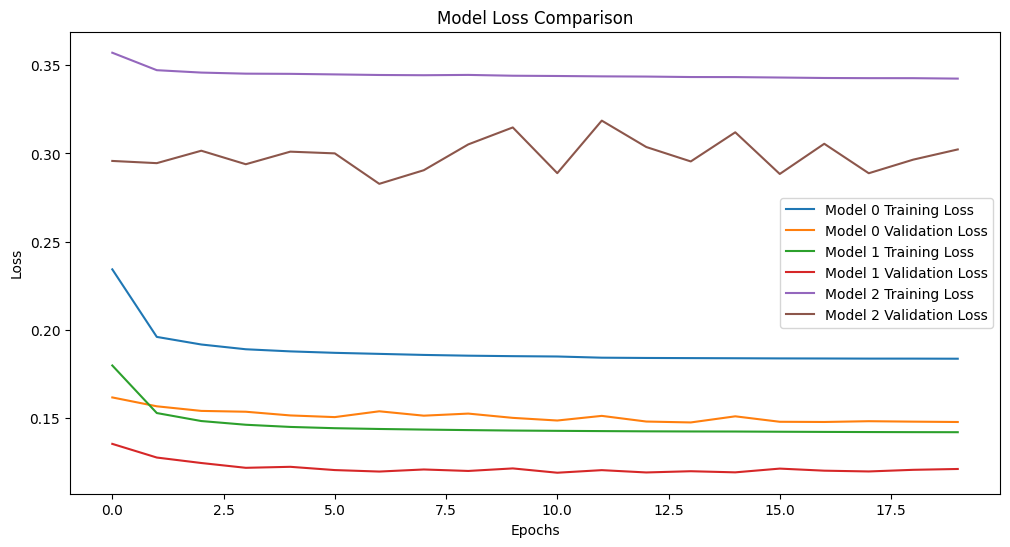

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


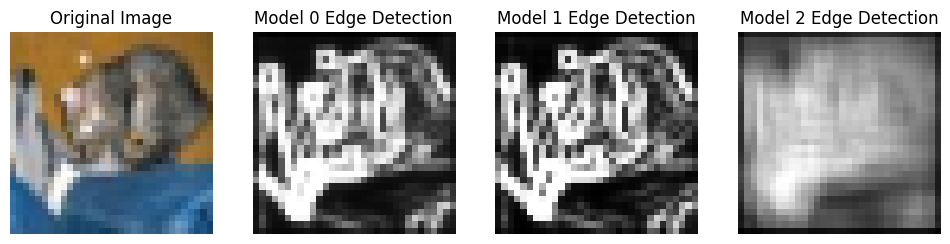

In [23]:
#######model2####
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dropout, Add, Input
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

tf.random.set_seed(2020)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

def apply_sobel_filter(images):
    grey_images = tf.image.rgb_to_grayscale(images)
    sobel_edges = tf.image.sobel_edges(grey_images)
    sobel_x = sobel_edges[..., 0]
    sobel_y = sobel_edges[..., 1]
    sobel_images = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))
    return sobel_images.numpy()

sobel_train = apply_sobel_filter(x_train)
sobel_test = apply_sobel_filter(x_test)

# Define the first model
model0 = Sequential([
    Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Conv2D(1, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4))
])

model0.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam())

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history0 = model0.fit(x_train, sobel_train, batch_size=32, epochs=20, validation_data=(x_test, sobel_test), shuffle=True, callbacks=[reduce_lr])

# Define the second model
model1 = Sequential([
    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), input_shape=(32, 32, 3)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(1, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
])

model1.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam())

history1 = model1.fit(x_train, sobel_train, batch_size=32, epochs=20, validation_data=(x_test, sobel_test), shuffle=True, callbacks=[reduce_lr])

# Define the third model
model2 = Sequential([
    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), input_shape=(32, 32, 3)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(1, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
])

model2.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam())

history2 = model2.fit(datagen.flow(x_train, sobel_train, batch_size=32), epochs=20, validation_data=(x_test, sobel_test), shuffle=True, callbacks=[lr_scheduler])

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(history0.history['loss'], label='Model 0 Training Loss')
plt.plot(history0.history['val_loss'], label='Model 0 Validation Loss')
plt.plot(history1.history['loss'], label='Model 1 Training Loss')
plt.plot(history1.history['val_loss'], label='Model 1 Validation Loss')
plt.plot(history2.history['loss'], label='Model 2 Training Loss')
plt.plot(history2.history['val_loss'], label='Model 2 Validation Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Compare the edge detection results
def learned_edge_detection(model, img):
    img = np.expand_dims(img, axis=0)
    edge_detected_img = model.predict(img)
    return edge_detected_img[0]

def compare_edge_detection(model0, model1, model2, img):
    edge0 = learned_edge_detection(model0, img)
    edge1 = learned_edge_detection(model1, img)
    edge2 = learned_edge_detection(model2, img)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(edge0, cmap='gray')
    plt.title('Model 0 Edge Detection')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(edge1, cmap='gray')
    plt.title('Model 1 Edge Detection')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(edge2, cmap='gray')
    plt.title('Model 2 Edge Detection')
    plt.axis('off')

    plt.show()

img_example = x_test[0]
compare_edge_detection(model0, model1, model2, img_example)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.2790 - val_loss: 0.1639 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1961 - val_loss: 0.1579 - learning_rate: 0.0010
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1920 - val_loss: 0.1553 - learning_rate: 0.0010
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1899 - val_loss: 0.1566 - learning_rate: 0.0010
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1883 - val_loss: 0.1537 - learning_rate: 0.0010
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1874 - val_loss: 0.1532 - learning_rate: 0.0010
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1868 - val_loss: 0.1518 - learning_rate: 0.0010
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1861 - val_loss: 0.1531 - learning_rate: 0.0010
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1858 - val_loss: 0.1528 - learning_rat

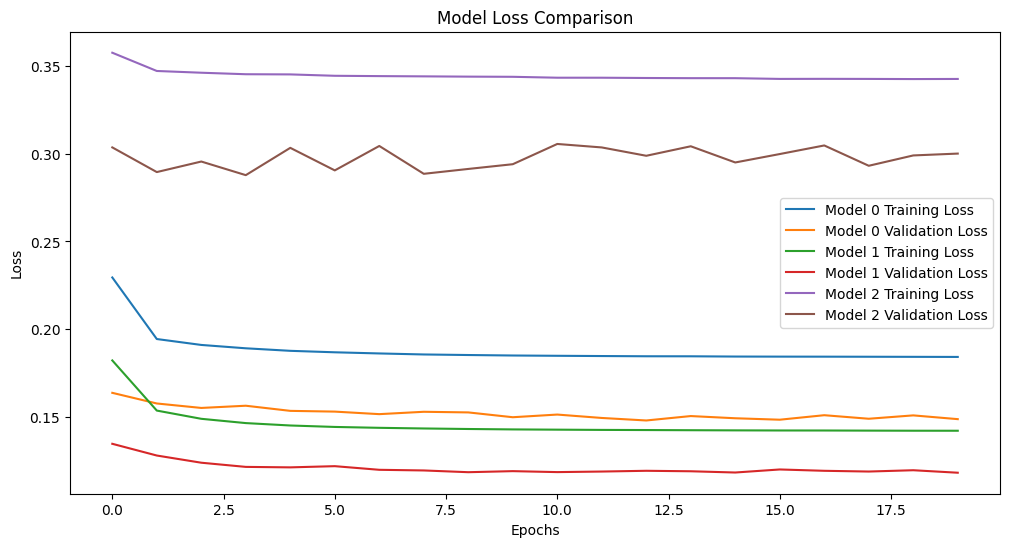

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


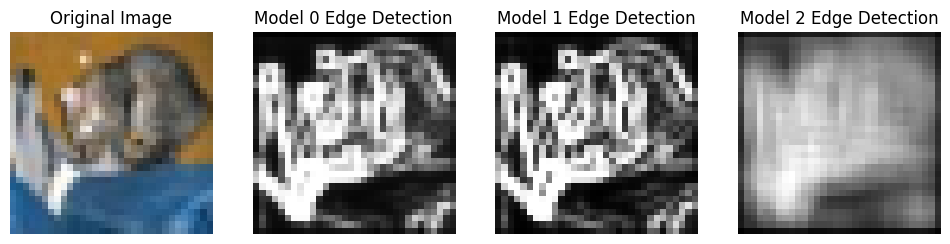

In [24]:
## 최종 테스트 수행 결과 ##

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dropout, Add, Input
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

tf.random.set_seed(2020)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

def apply_sobel_filter(images):
    grey_images = tf.image.rgb_to_grayscale(images)
    sobel_edges = tf.image.sobel_edges(grey_images)
    sobel_x = sobel_edges[..., 0]
    sobel_y = sobel_edges[..., 1]
    sobel_images = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))
    return sobel_images.numpy()

sobel_train = apply_sobel_filter(x_train)
sobel_test = apply_sobel_filter(x_test)


model0 = Sequential([# 첫 학습 모델 정의
    Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Conv2D(1, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4))
])

model0.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam())

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history0 = model0.fit(x_train, sobel_train, batch_size=32, epochs=20, validation_data=(x_test, sobel_test), shuffle=True, callbacks=[reduce_lr])


model1 = Sequential([# model1 정의
    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), input_shape=(32, 32, 3)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(1, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
])

model1.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam())

history1 = model1.fit(x_train, sobel_train, batch_size=32, epochs=20, validation_data=(x_test, sobel_test), shuffle=True, callbacks=[reduce_lr])


model2 = Sequential([#  model2 정의
    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), input_shape=(32, 32, 3)),
    BatchNormalization(),
    LeakyReLU(), #ReLU 함수 변형으로 음수 입력에 대해 작은 기울기를 허용하여 기울기 소실 문제 완화
    Dropout(0.3), #신경망의 일부 뉴런 무작위로 제외해 과적합 방지
    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(1, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
])

model2.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam())
# 평균 절대 오차(MAE):모델이 예측과 실제 값 간의 평균 절대 차이를 최소화하도록 학습
# Adam 옵티마이저: 학습률 자동으로 조정하는 적응형 옵티마이저
lr_scheduler = LearningRateScheduler(lambda epoch: 0.001 * (0.5 ** (epoch // 5)))

history2 = model2.fit(datagen.flow(x_train, sobel_train, batch_size=32), epochs=20, validation_data=(x_test, sobel_test), shuffle=True, callbacks=[lr_scheduler])
#학습률 스케줄러를 콜백으로 지정

plt.figure(figsize=(12, 6))# 손실율 측정 시각화
plt.plot(history0.history['loss'], label='Model 0 Training Loss')
plt.plot(history0.history['val_loss'], label='Model 0 Validation Loss')
plt.plot(history1.history['loss'], label='Model 1 Training Loss')
plt.plot(history1.history['val_loss'], label='Model 1 Validation Loss')
plt.plot(history2.history['loss'], label='Model 2 Training Loss')
plt.plot(history2.history['val_loss'], label='Model 2 Validation Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


def learned_edge_detection(model, img): # 각 모델 에지 검출 결과 비교
    img = np.expand_dims(img, axis=0)
    edge_detected_img = model.predict(img)
    return edge_detected_img[0]

def compare_edge_detection(model0, model1, model2, img_example):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(img_example, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(learned_edge_detection(model0, img_example), cmap='gray')
    plt.title('Model 0 Edge Detection')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(learned_edge_detection(model1, img_example), cmap='gray')
    plt.title('Model 1 Edge Detection')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(learned_edge_detection(model2, img_example), cmap='gray')
    plt.title('Model 2 Edge Detection')
    plt.axis('off')

    plt.show()

compare_edge_detection(model0, model1, model2, x_test[0])



## 학습 결과 ##
#CPU 환경에서는 최소 38분, 최대 58분 이상 소요
#GPU 환경에서는 최소 15분, 최대 20분 대역 소요
## 학습 결과: 단시간에 테스트하기가 어렵다.
#4. 이미지 에지 감지 결과
#Model 0: 에지 감지 결과 명확하나 노이즈 많이 포함.

#Model 1: 에지 감지 부드러워졌으나 여전히 일부 노이즈 존재.

#Model 2: 에지 감지가 가장 부드럽고 노이즈 감소
